In [1]:
import tripyview.sub_notebookheader as nb_setup
# which_matplotlib = 'inline' (default), 
#                    'notebook'(jupyter notebook), 
#                    'widget'(jupyterlab)
nb_setup.init_notebook(which_matplotlib="inline")
# centralized autoimport of: 
# import os
# import warnings
# import time as clock
# import numpy as np
# import xarray as xr
# import shapefile as shp
# import tripyview as tpv
# client, use_existing_client = None, "tcp://0.0.0.0:0000"
# use_existing_client='tcp://127.0.0.1:42761'

/albedo/home/pscholz/tripyview
 -> Warming up Numba neighborhood connectivity
 -> Warming up Numba grid kernel
 -> Warming up Numba kernels for vec_r2g
 -> Warming up Numba lsmask compute
 -> Warming up Numba smoothers


### INFO:
To compute especially on large unstructured grids #vertices>1M, you need to run this notebook in parallel (do_parallel=True) on several workers (parallel_nprc...is the number of dask worker that can be allocated, parallel_tmem...is the maximum available RAM that will be distributed between the dask workers). Therefor allocate a full !!! COMPUTE NODE !!! (admins might not be happy if you do this in parallel on a login node) of a HPC of your choice with as much memory (RAM) as you can get to run this notebook!

In [2]:
# parameters
#___Dask Client Parameters____________________________________________________________
do_papermill      = False
do_parallel       = True
parallel_nprc     = 64   # number of total processes
parallel_nthread  = 2    # number of threads per worker --> number worker = parallel_nprc/parallel_nthread
parallel_tmem     = 256  # max. available RAM

#___Mesh Path & Save Path_____________________________________________________________
# mesh_path ='/work/ollie/projects/clidyn/FESOM2/meshes/core2/'
# mesh_path         = '/albedo/work/user/pscholz/mesh_fesom2.0/core2_srt_dep@node/'
mesh_path         = '/albedo/work/user/pscholz/mesh_fesom2.0/dart/'
# mesh_path         = '/work/ba1264/a270210/model/input/fesom2/dart/'

save_path         = None #'~/tripyview/Results/ozgures/coastalmesh'
save_fname        = None # filename from papermill come in through save_fname
tripyrun_name     = None # papermill workflow name of notebook 
tripyrun_analysis = None # papermill diagnostic driver
tripyrun_spath_nb = None # papermill path to processed notebooks
tripyrun_spath_fig= None # papermill path to processed figures

#___Data Path & Input Names___________________________________________________________
input_paths   = list()
# input_paths.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_jayne_bin_ck0.1/5/')
# input_paths.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_nycander_bin_ck0.1/5/')
# input_paths.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_stormtide_bin_ck0.1/5/')
# input_paths.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke_ctrl_ck0.1/5/')
# input_paths.append('/work/ab0995/a270210/runtime/awicm3-v3.1_refactoring/TCO319L137-DART/hist1950d/outdata/fesom/')
input_paths.append('/albedo/work/user/pscholz/results/dart_linfs_pc0_ctrl_1/1/')

input_names   = list()
# input_names.append('TKE+IDEMIX, jayne')
# input_names.append('TKE+IDEMIX, nycander')
# input_names.append('TKE+IDEMIX, stormtide')
# input_names.append('TKE')
input_names.append('dart test')

# n_cycl: which spinupcycle should be plottet if do_allcycl all spinupcycles from [1...n_cycle] are plottet, if None path is directly used
n_cycl      = None
do_allcycl  = False
vname       = 'temp'
year        = [1958, 1961]
mon         = None
day         = None
record      = None 
box         = None
depth       = 1000
do_data_r2g = True

#___Define Reference Data, Year, Mon ...______________________________________________
# do anomaly plots in case ref_path is not None
ref_path  = None #'/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke_ctrl_ck0.1/5/'
ref_name  = None #'TKE'
ref_year  = None #[1979, 2019]
ref_mon   = None
ref_day   = None
ref_record= None

#___Define Climatology________________________________________________________________
which_clim= 'phc3'
clim_path = '/albedo/work/projects/p_fesom/FROM-OLLIE/FESOM2/hydrography/phc3.0/phc3.0_annual.nc'
# clim_path = '/pool/data/AWICM/FESOM2/INITIAL/phc3.0/phc3.0_annual.nc'

#___Define Colormap Parameters________________________________________________________
# papermill doesnt like multi variable alignment in a single line
cstr      = 'blue2red'
cnum      = 15
cref      = None
crange    = None
cmin      = None
cmax      = None
cfac      = None
climit    = None
chist     = True
ctresh    = 0.995

ref_cstr  = 'wbgyr'
ref_cnum  = 15
ref_cref  = None
ref_crange= None
ref_cmin  = None
ref_cmax  = None
ref_cfac  = None
ref_climit= None
ref_chist = True
ref_ctresh= 0.995

#___Define Plot Parameters____________________________________________________________
ncol              = 2      # number of pannel columns in figure
nrow              = None
proj              = 'rob' 
box               = [-180, 180, -90, 90]
do_plt            = 'tcf' #'tcf'  # plot pcolor (tpc) or contourf (tcf)
plt_contb         = True   # background contour line (thin)
plt_contf         = False  # contour line of main colorbar steps 
plt_contr         = False  # contour line of reference value 
plt_contl         = False  # label contourline of main colorbar steps 
do_rescale        = None   # rescale data: None, 'log10', 'slog10', np.array(...)
do_lsm            ='fesom' # 'fesom', 'bluemarble', 'etopo', 'stock'
do_mesh           = False, 
mesh_opt          = dict({'color':'k', 'linewidth':0.10})
do_enum           = False  # do enumeration of panels
do_reffig         = True   # plot reference fig when doing anomalies 
do_clim           = False   # plot climatolgy values when doing absoluts
ax_title          = None
cb_label          = None
save_dpi          = 150
save_fmt          = ['png']

In [3]:
# start parallel dask client if do_parallel=True
client = tpv.shortcut_setup_daskclient(client, 
                                       use_existing_client, 
                                       do_parallel, 
                                       parallel_nprc, 
                                       parallel_tmem,
                                       threads_per_worker=parallel_nthread)

No existing Dask cluster found at: tcp://0.0.0.0:0000
Started a new Dask client: <Client: 'tcp://127.0.0.1:32887' processes=64 threads=64, memory=214.58 GiB>


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: //proxy/8787/status,
Dashboard: //proxy/8787/status,Workers: 64
Total threads: 64,Total memory: 214.58 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:32887,Workers: 64
Dashboard: //proxy/8787/status,Total threads: 64
Started: Just now,Total memory: 214.58 GiB
Comm: tcp://127.0.0.1:36935,Total threads: 1
Dashboard: //proxy/37467/status,Memory: 3.35 GiB
Nanny: tcp://127.0.0.1:45389,


In [4]:
#___LOAD FESOM2 MESH___________________________________________________________________________________
mesh=tpv.load_mesh_fesom2(mesh_path, do_rot='None', do_info=True)

#______________________________________________________________________________________________________
# create input_path spinupcycle structure
input_paths, input_names, ref_path, ref_name = tpv.shortcut_setup_pathwithspinupcycles(input_paths, input_names, ref_path, ref_name, n_cycl, do_allcycl)

#______________________________________________________________________________________________________
cinfo=tpv.set_cinfo(cstr, cnum, crange, cmin, cmax, cref, cfac, climit, chist, ctresh)
ref_cinfo=None
if (ref_path != None): 
    if ref_year   is None: ref_year   = year
    if ref_mon    is None: ref_mon    = mon
    if ref_record is None: ref_record = record
    cinfo['cref']=0.0 
    ref_cinfo=tpv.set_cinfo(ref_cstr, ref_cnum, ref_crange, ref_cmin, ref_cmax, ref_cref, ref_cfac, ref_climit, ref_chist, ref_ctresh)
    
#______________________________________________________________________________________________________    
# concatenate ref_path and input_path together if is not None,  concatenate list = list1+list2
input_paths, input_names = tpv.shortcut_setup_concatinputrefpath(input_paths, input_names, ref_path, ref_name)

# #______________________________________________________________________________________________________
# # define index regions --> reading shape files
# box = tpv.shortcut_setup_boxregion(box_region)

#______________________________________________________________________________________________________
# set predefined chunks size here! The optimized worker memory dependent chunk size is computed internally. 
# see def compute_optimal_chunks(path, client=None, varname=None, opti_dim='h', opti_chunkfrac=0.10):
# The here presetted values are used when tpv.load_data_fesom2( ..., opti_dim=None', ...), otherwise the 
# chunks are choosen to be not larger than 10% of the worker memory tpv.load_data_fesom2( ..., 
# opti_dim='hori', opti_chunkfrax=0.1, ...). Optimized can be the horizontal, vertical or time 
# dimension opti_dim: 'h', 'v', 'hv', 'vh', 't', 'off', None
chunks = dict({
               'elem' : 'auto', 'nod2' : 'auto', 'edg_n': 'auto',
               'nz1'  : 'auto', 'nz'   : 'auto', 
               'time' : 'auto', 
               }) 

 > found *.jlib file: /albedo/work/user/pscholz/mesh_fesom2.0/dart
 > load  *.jlib file: tripyview_mesh_dart_focus0.jlib
___FESOM2 MESH INFO________________________
 > path            = /albedo/work/user/pscholz/mesh_fesom2.0/dart
 > id              = dart
 > do rot          = None
 > [al,be,ga]      = 50, 15, -90
 > do augmpbnd     = True
 > do cavity       = False
 > do lsmask       = True
 > do earea,eresol = True, True
 > do narea,nresol = True, True
___________________________________________
 > #node           = 3160340
 > #elem           = 6262485
 > #lvls           = 70
___________________________________________


In [5]:
t0 = clock.time()
# clean up garabage on workers before the party starts!
if client is not None: client.run(gc.collect)
    
data_list = list()
#___APPEND ABS CLIMATOLOGY_____________________________________________________
if (vname in ['temp', 'salt', 'pdens'] or 'sigma' in vname) and (depth != 'bottom') and do_clim and (ref_path is None): 
    ts = clock.time()
    clim_vname = vname
    if   vname=='temp' and  which_clim.lower()=='woa18': clim_vname = 't00an1'
    elif vname=='salt' and  which_clim.lower()=='woa18': clim_vname = 's00an1'
    clim = tpv.load_climatology(mesh, clim_path, clim_vname, depth=depth)
    print(' --> elasped time to load clim: {:3.2f} min.'.format( (clock.time()-ts)/60  ))        
    print(' --> clim uses {:3.2f} Gb:'.format(clim.nbytes/(1024**3)))
    data_list.append(clim)    
    del(clim)
    
    
#___LOAD FESOM2 DATA___________________________________________________________
for ii, (datapath, descript) in enumerate(zip(input_paths, input_names)):
    print(ii, datapath, descript)
    ts = clock.time()
    #__________________________________________________________________________
    yeari, moni, dayi, recordi = year, mon, day, record
    if (ii==0) and (ref_path != None): yeari, moni, dayi, recordi = ref_year, ref_mon, ref_day, ref_record

    #__________________________________________________________________________
    # create shortcut for input parameter
    input_dict = dict({'year':yeari, 'mon':moni, 'day':dayi, 'record':recordi, 'depth':depth, 
                       'descript':descript, 'do_ie2n':False, 'do_rot':do_data_r2g, 
                       'chunks':chunks, 'do_parallel':do_parallel, 'do_load':True, 'do_persist':False, 
                       'client':client, 'opti_dim':'h' , 'opti_chunkfrac':0.06,
                       'do_info':False,})
    
    #__________________________________________________________________________
    if isinstance(depth,str): # if depth == 'bottom' or 'bottom-1'
        shift = int(depth.split('-')[1]) if '-' in depth else 0
        data  = tpv.load_data_fesom2(mesh, datapath, vname=vname, **{**input_dict, 'depth':None, 'do_zarithm':None}) 
        dim_v ='nz' if 'nz' in data.dims else 'nz1'
        data  = data.isel({dim_v:xr.DataArray(mesh.n_iz-shift, dims='nod2'), 'nod2':xr.DataArray(range(0,mesh.n2dn), dims='nod2')})
        data[vname].attrs['str_ldep']=', '+depth
        data[vname].attrs['str_lsave'] = data[vname].attrs['str_lsave']+'_bot-{:02d}'.format(shift)

    else:
        #______________________________________________________________________
        if vname=='Kv*N2':
            data  = tpv.load_data_fesom2(mesh, datapath, vname='Kv', **input_dict) 
            data2 = tpv.load_data_fesom2(mesh, datapath, vname='N2', **input_dict) 
            data['Kv'].data = data['Kv'].data * data2['N2'].data
            data = data.rename(dict({'Kv':'Kv*N2'}))
            data['Kv*N2'].attrs['units'], data['Kv*N2'].attrs['description'], data['Kv*N2'].attrs['long_name'] =  '$m^2/s^3$', '(Kv)*(N^2)', '$\\overline{{Kv}} \\cdot \\overline{{N^2}}$'
            del(data2)
        #______________________________________________________________________
        elif vname=='KvN2/N2':
            data  = tpv.load_data_fesom2(mesh, datapath, vname='KvN2', **input_dict)
            data2 = tpv.load_data_fesom2(mesh, datapath, vname='N2'  , **input_dict)
            data['KvN2'].data = data['KvN2'].data / data2['N2'].data
            data  = data.rename(dict({'KvN2':'KvN2/N2'}))
            data['KvN2/N2'].attrs['units'], data['KvN2/N2'].attrs['description'], data['KvN2/N2'].attrs['long_name'] = '$m^2/s$', '(Kv*N)/N2', '$\\overline{{Kv \\cdot N^2}} / \\overline{{N^2}}$'
            del(data2) 
        #______________________________________________________________________
        elif vname=='iwe_Tbot':    
            data = tpv.load_data_fesom2(mesh, datapath, vname=vname, **input_dict) 
            data = data.isel(nz=xr.DataArray(mesh.n_iz, dims='nod2'), nod2=xr.DataArray(range(0,mesh.n2dn), dims='nod2'))
            data = data * xr.DataArray(mesh.zlev[mesh.n_iz-1]-mesh.zlev[mesh.n_iz], dims='nod2') * 1030 * 0.5
            # compute global value of total energy input in TW
            aux  = data['iwe_Tbot'].copy()*xr.DataArray(mesh.n_area, dims='nod2')*1.0e-12
            data['iwe_Tbot'].attrs['descript'] = '{:s}, $E_{{tot}}$={:2.3f} TW'.format(data['iwe_Tbot'].attrs['descript'], aux.sum(dim='nod2').data)
        #______________________________________________________________________
        elif vname=='EKE':
            data  = tpv.load_data_fesom2(mesh, datapath, vname='ke_Umean'  , **input_dict) 
            datau2 = tpv.load_data_fesom2(mesh, datapath, vname='ke_U2mean', **input_dict) 
            data['ke_Umean'].data = datau2['ke_U2mean'].data/2 - (data['ke_Umean'].data**2)/2
            
            datau  = tpv.load_data_fesom2(mesh, datapath, vname='ke_Vmean' , **input_dict) 
            datau2 = tpv.load_data_fesom2(mesh, datapath, vname='ke_V2mean', **input_dict)   
            data['ke_Umean'].data = data['ke_Umean'].data + datau2['ke_V2mean'].data/2 - (datau['ke_Vmean'].data**2)/2
                                
            data = data.rename(dict({'ke_Umean':'EKE'}))
            data['EKE'].attrs['units'], data['EKE'].attrs['description'], data['EKE'].attrs['long_name'] =  '$m^2/s^2$', 'EKE', 'Eddy Kinetic Energy'
            del(datau, datau2)
        #______________________________________________________________________
        else:
            data = tpv.load_data_fesom2(mesh, datapath, vname=vname, **input_dict)
    
    #__________________________________________________________________________
    # check if data where loaded
    if data is None: raise ValueError(f'data == None, data could not be readed, your path:{datapath} might be wrong!!!')
    print(' --> elasped time to load {:s} data: {:3.2f} min.'.format(vname, (clock.time()-ts)/60  ))        
    print(' --> data uses {:3.2f} Gb:'.format(data.nbytes/(1024**3)))
    print('')
        
    #__________________________________________________________________________
    # create reference data if given 
    if (ii==0) and (ref_path != None):
        data_ref = data
        if do_reffig: data_list.append(data_ref) 
        continue
        
    #__________________________________________________________________________
    # compute anomaly 
    if (ref_path != None):
        data_list.append(tpv.do_anomaly(data, data_ref))  
    # compute absolute    
    else:
        data_list.append(data)  
    del(data)
    if client is not None: client.run(gc.collect)
        
if (ref_path != None): del(data_ref)
# print(' --> total elasped time to process data: {:3.3f} min.'.format( (clock.time()-t0)/60  )) 
print(' --> total elasped time to process data: {:3.3f} sec.'.format( (clock.time()-t0)  )) 

0 /albedo/work/user/pscholz/results/dart_linfs_pc0_ctrl_1/1/ dart Test
 --> elasped time to load temp data: 0.09 min.
 --> data uses 0.05 Gb:

 --> total elasped time to process data: 5.847 sec.


--> cmin/cmax: norm: -1.749318/21.588711, hist: -0.734114/13.478745, fin: -0.734114/13.478745
{'cstr': 'blue2red', 'cnum': 15, 'chist': True, 'ctresh': 0.995, 'cnlab': 8, 'cmin': np.float64(-0.73), 'cmax': np.float64(13.48), 'cref': np.float64(6.0), 'cmap': <matplotlib.colors.ListedColormap object at 0x154e5c1736a0>, 'clevel': array([-1. , -0.5,  0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,
        4.5,  5. ,  5.5,  6. ,  6.5,  7. ,  7.5,  8. ,  8.5,  9. ,  9.5,
       10. , 10.5, 11. , 11.5, 12. , 12.5, 13. , 13.5]), 'clab': array([ 0.,  2.,  4.,  6.,  8., 10., 12.])}
 --> plot bot    chunk:0|


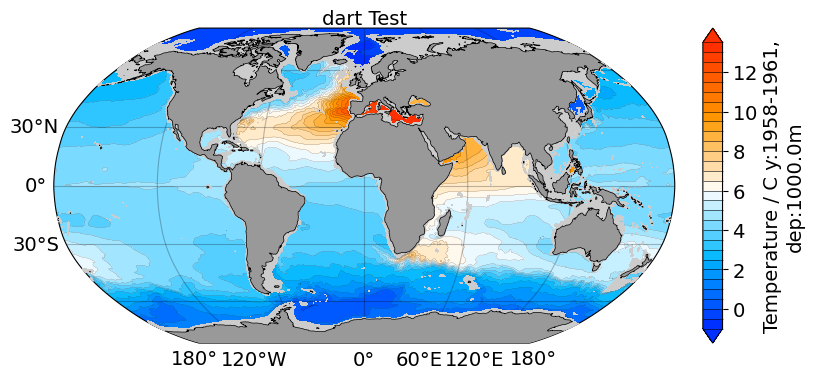

 --> elasped time to plot data: 0.40 min.


In [6]:
#___PLOT FESOM2 DATA___________________________________________________________________________________
ts = clock.time()
ndat   = len(data_list)
if   ncol != None: 
    ncol0  = np.min([ncol,ndat])    
    nrow0  = np.ceil(ndat/ncol0).astype('int')
elif nrow != None: 
    nrow0  = np.min([nrow,ndat])    
    ncol0  = np.ceil(ndat/nrow0).astype('int')
    
idx=1 if do_clim else 0       
svname = list(data_list[idx].data_vars)[0]
slabel = data_list[idx][svname].attrs['str_lsave']

#______________________________________________________________________________________________________
# do save filename path
spath  = save_path
sfpath = None
if spath!=None: 
    sfpath=list()
    for sfmt in save_fmt: sfpath.append( os.path.join(spath,'{:s}_{:s}_{:s}.{:s}'.format(svname, proj, slabel, sfmt)) )
if save_fname!=None: sfpath = [save_fname] # --> needed for diagrun papermille functionality

#______________________________________________________________________________________________________
# do colorbar either single cbar or ref_cbar + anom_cbar
if (ref_path != None) and do_reffig: cb_plt, cb_plt_single, cinfo0 = [1]+[2]*(nrow0*ncol0-1), False, [ref_cinfo.copy(), cinfo.copy()]
else: cb_plt, cb_plt_single, cinfo0 = True, True, cinfo.copy() 

#__________________________________________________________________________________________________
hfig, hax, hcb = tpv.plot_hslice(mesh, data_list, cinfo=cinfo0, box=box, nrow=nrow0, ncol=ncol0, proj=proj, do_rescale=do_rescale,  
                                do_plt=do_plt, plt_contb=plt_contb, plt_contf=plt_contf, plt_contr=plt_contr, plt_contl=plt_contl, do_enum=do_enum, 
                                ax_opt=dict({'fig_sizefac':2.0, 'cb_plt':cb_plt, 'cb_plt_single':cb_plt_single, 'cb_pos':'vertical', 'cb_h':'auto',}), # 'fs_label':14, 'fs_ticks':14, 'ax_dt':1.0}),
                                cbl_opt=dict(), cb_label=cb_label, cbtl_opt=dict(),
                                do_save=sfpath, save_dpi=save_dpi) 

print(' --> elasped time to plot data: {:3.2f} min.'.format( (clock.time()-ts)/60  ))        

In [7]:
if do_papermill and do_parallel and client is not None: client.shutdown()